# example: Keras 2D convolutional neural network on MNIST

In [1]:
import datetime
import keras
from keras import activations
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.utils import plot_model
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style = 'ticks')
sns.set_palette('husl')
import talos as ta
from vis.visualization import visualize_activation
from vis.visualization import visualize_saliency
from vis.utils import utils

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [17, 10]

In [3]:
# input dimensions
img_x       = 28
img_y       = 28

In [4]:
# Load MNIST data into training and testing datasets. The x data are the features and the y data are the labels.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

num_classes = 10

In [5]:
# Reshape the data into a 4D tensor (sample_number, x_img_size, y_img_size, num_channels).
# MNIST is greyscale, which corresponds to a single channel/dimension.
# Alternatively, color, for example RGB, would correspond to three channels/dimensions.
x_train     = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test      = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)

# Cast the data as type float32.
x_train     = x_train.astype('float32')
x_test      = x_test.astype('float32')
x_train     = x_train / 255
x_test      = x_test  / 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
# Convert class vectors to binary class matrices for use in the categorical_crossentropy loss.
y_train     = keras.utils.to_categorical(y_train, num_classes)
y_test      = keras.utils.to_categorical(y_test, num_classes)

In [7]:
y_train[0] # labels

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [8]:
y_train.shape

(60000, 10)

In [9]:
x_train[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

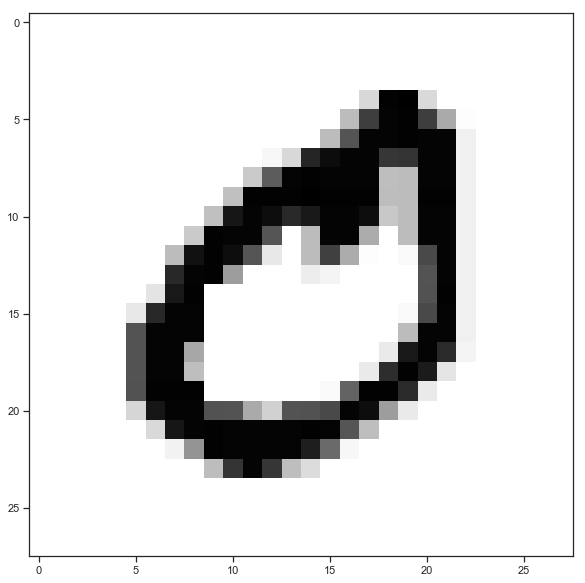

In [10]:
plt.imshow(
    x_train[21].reshape(28, 28),
    cmap          = "Greys",
    interpolation = "nearest"
)
plt.show()

In [11]:
model = Sequential()

# Add a 2D convolutional layer to process the 2D input (image) data.
model.add(
    Conv2D(
        32,                       # number of output channels
        kernel_size = (3, 3),     # kernel: 5 x 5 moving window
        strides     = (1, 1),     # kernel strides in the x and y dimensions
        activation  = 'relu',     # activation function: ReLU
        input_shape = input_shape # input size/shape
    )
)
# Add a 2D max pooling layer.
model.add(
    MaxPooling2D(
        pool_size   = (2, 2),     # size of the pooling in the x and y dimensions
        strides     = (2, 2)      # strides in the x and y dimensions
    )
)
# Add a convolutional layer. The input tensor for this layer is (batch_size, 28, 28, 32),
# where 28 x 28 corresponds to the input dimensions and 32 is the number of output channels from the previous layer.
model.add(
    Conv2D(
        64,                       # number of output channels
        (5, 5),                   # kernel: 5 x 5 moving window
        strides     = (1, 1),     # kernel strides in x and y dimensions -- default: (1, 1)
        activation  = 'relu'      # activation function: ReLU
    )
)
# Add a dropout layer.
model.add(Dropout(0.5))
# Add a 2D max pooling layer.
model.add(
    MaxPooling2D(
        pool_size   = (2, 2)      # size of the pooling in the x and y dimensions
    )
)
# Flatten the output from convolutional layers to prepare them for input to fully-connected layers.
model.add(Flatten())
# Specify a fully-connected layer.
model.add(
    Dense(
        1000,                     # number of nodes
        activation  = 'relu'      # activation function: ReLU
    )
)
# Specify a fully-connected output layer.
model.add(
    Dense(
        num_classes,              # number of classes
        activation  = 'softmax',  # softmax classification
        name        = "preds"
    )
)
plot_model(model, to_file="model.png")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1025000   
__________

In [12]:
model.compile(
    loss            = keras.losses.categorical_crossentropy,
    optimizer       = keras.optimizers.Adam(), # alternative: keras.optimizers.SGD(lr = 0.01)
    metrics         = ['accuracy']
)

# Define a callback class which is to be passed to the model fitting function
# as an element of a list of possible callbacks.
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs = {}):
        self.acc = []
        self.val_acc = []
    def on_epoch_end(self, batch, logs = {}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

history = AccuracyHistory()

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath       = 'best_model.{epoch:02d}-{val_loss:.2f}.h5',
    monitor        = 'val_loss',
    save_best_only = True
)

In [13]:
epochs = 100

model.fit(
    x_train,
    y_train,
    batch_size      = 512,
    epochs          = epochs,
    verbose         = False,
    validation_data = (x_test, y_test),
    callbacks       = [history, checkpoint]
)
score = model.evaluate(x_test, y_test, verbose=False)

In [14]:
print('test loss:', score[0])
print('test accuracy:', score[1])

test loss: 0.024342830512404406
test accuracy: 0.9942


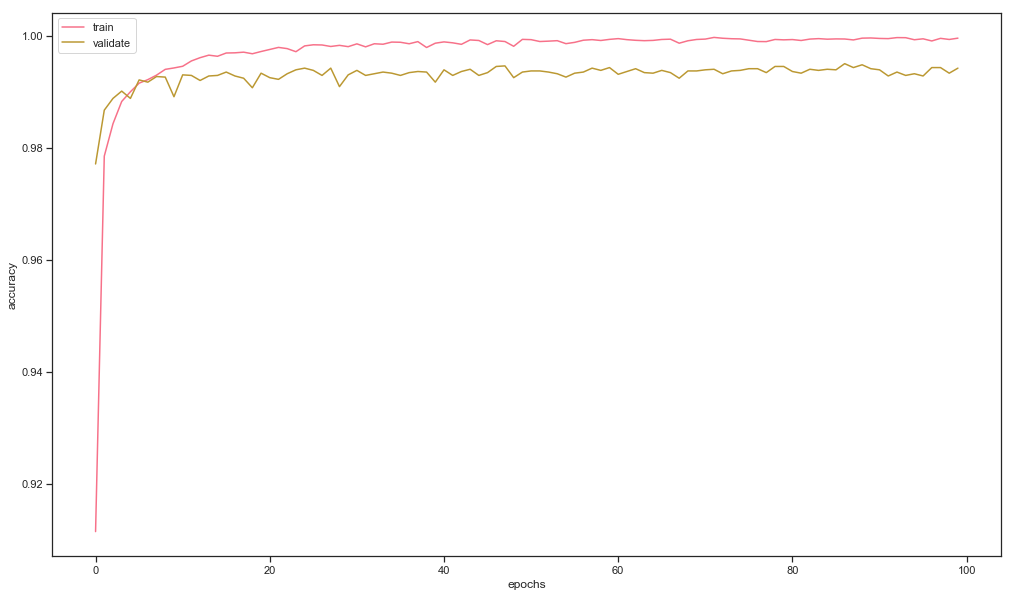

In [15]:
plt.plot(history.acc, label='train')
plt.plot(history.val_acc, label='validate')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# deep learning understanding

In deep learning research, researchers tend to focus on visualization of learned features of each neuron using various optimization-based algorithms. These optimization-based methods are currently divided into two categories: activation maximization and code inversion.

## activation maximization

In a convolutional neural network, each convolution layer has several learned template matching filters that maximize their output when a similar template pattern is found in an input image. The first convolution layer is straightforward to visualise; simply visualise the weights as an image. To see what the layer is doing, a simple option is to apply the filter over raw input pixels. Higher convolution filters operate on the outputs of lower convolution filters (which indicate the presence or absense of some template patterns), making them harder to interpret.

The idea of activation maximization is to generate an input image that maximizes the filter output activations. This approach enables us to see wat sorts of input patterns activate a particular filter.

- [example](https://github.com/raghakot/keras-vis/blob/master/examples/mnist/activation_maximization.ipynb)

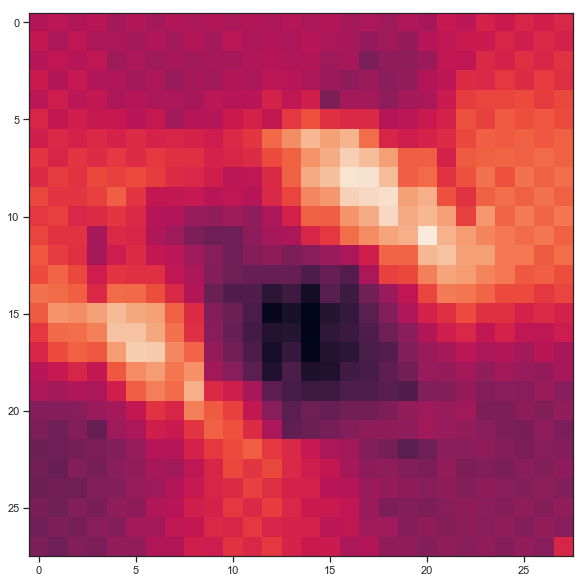

In [16]:
layer_idx = utils.find_layer_idx(model, 'preds')
model.layers[layer_idx].activation = activations.linear # Swap softmax for linear.
model = utils.apply_modifications(model)

filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx) #verbose=True

plt.imshow(img[..., 0]);

## saliency

- [Deep Inside Convolutional Networks: VisualisingImage Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf) (paper introducing the technique)
- [Beyond saliency: understanding convolutional neuralnetworks from saliency prediction on layer-wiserelevance propagation](https://arxiv.org/pdf/1712.08268.pdf)

Understanding how convolutional neural networks work is hard. There's a two-step understanding method called *Salient Relevance (SR) map* which aims to illuminate how deep convolutional neural networks recognise inputs and features from areas called *attention areas* therein. In this method, there is first a layer-wise relevance propagation (LRP) step which estimates a 'pixel'-wise relevance map over the input. Then there is constructed a context-aware saliency map from the LRP-generated map which predicts areas close to the foci of attention instead of isolated 'pixels' that the LRP reveals. This perhaps corresponds to recognition in the human visual system where information on regions is more important than information of pixels. So the original designers suggest that this saliency is something of a simulation of human visual recognision. The method seems to identify not only key pixels but also attention areas that contribute to the underlying neural network comprehension of inputs. So overall the salient relevance is a visual interface which unveils some of the visual attention of the network and reveals which type of objects the model has learned to recognize after training.

**A saliency map highlights those input elements that are most important for classification of the input.**

### input-specific class saliency map

Given an input ${I_{o}}$ (e.g. an image), a class ${c}$ and a classification convolutional neural network with the class score function ${S_{c}\left(I\right)}$, which is computed by the classification layer of the network, features of input ${I_{o}}$ can be ranked by their influence on the class score ${S_{c}\left(I_{o}\right)}$ in order to create a saliency map. In this case the saliency map specific to a specific input case. One interpretation of computing this image-specific class saliency is that the magnitude of the class score derivative indicates which input features require the least change to affect the class score the most.

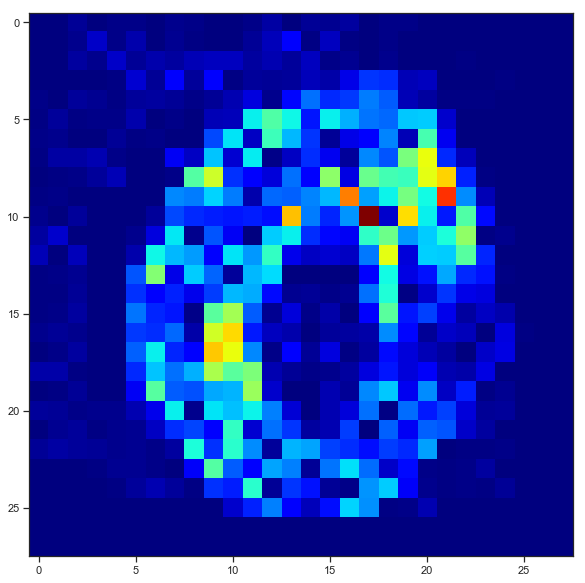

In [43]:
grads = visualize_saliency(model, layer_idx, filter_indices=filter_idx, seed_input=x_test[13], backprop_modifier='guided')
plt.imshow(grads, cmap='jet');

### class-saliency map extraction

In the original definition of saliency, a class saliency map is computed essentially by taking the mean of ten input-specific saliency maps with the ten inputs selected randomly. This approach is used here but using a sample of 100 images for the mean.

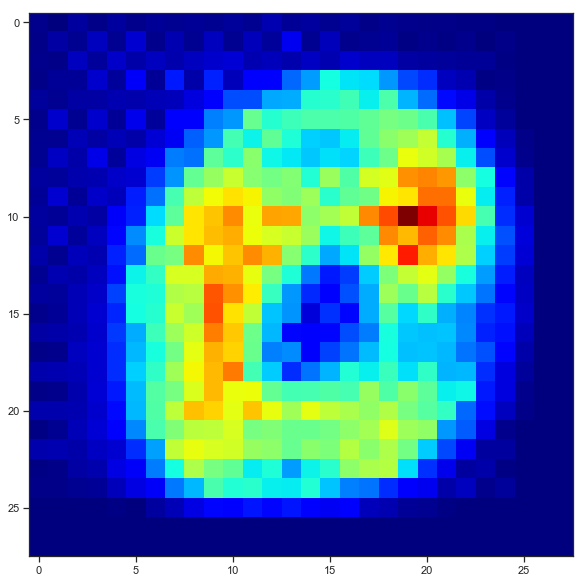

In [68]:
# get indices in test dataset of instances of the class 0
y_test_non_categorical = np.argmax(y_test, axis=1)
indices = [i for i, j in enumerate(y_test_non_categorical) if j == 0]
# get the instances
x_test_0 = [x_test[i] for i in indices]

sample_size = 100
saliencies = []
for i in list(range(0, sample_size - 1)):
    saliencies.append(visualize_saliency(model, layer_idx, filter_indices=filter_idx, seed_input=x_test_0[i], backprop_modifier='guided'))

plt.imshow(np.mean(saliencies, axis=0), cmap='jet');

### class-saliency map statistical uncertainties

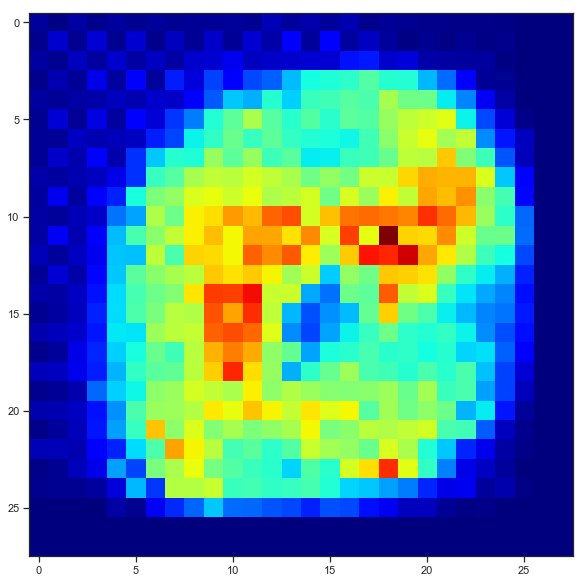

In [75]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sem.html
plt.imshow(stats.sem(saliencies, axis=0), cmap='jet');

### *reshaped* to 1D class-saliency map with statistical uncertainties scaled by a factor of 10

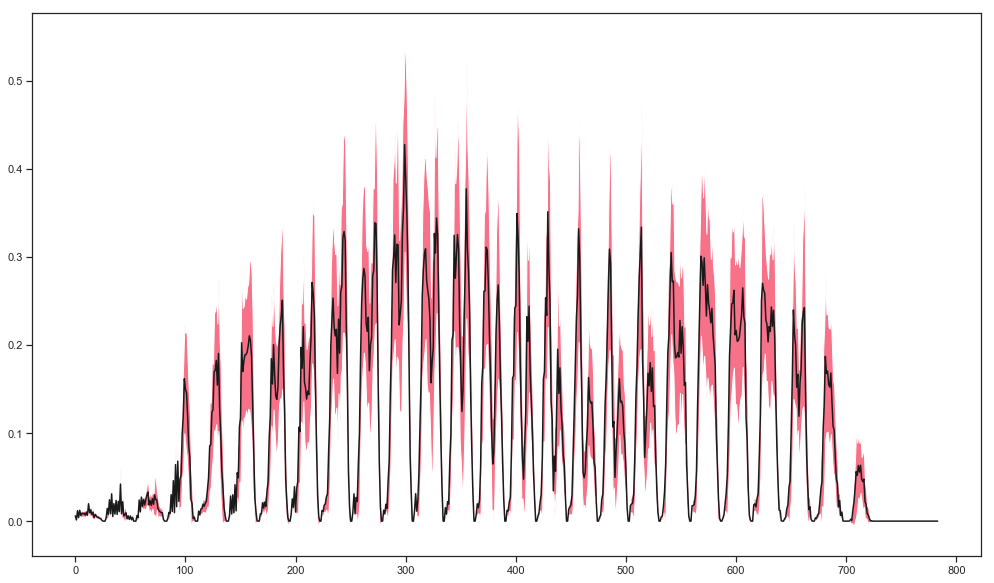

In [95]:
mean                    = np.mean(saliencies,   axis=0)
statistical_uncertainty = stats.sem(saliencies, axis=0)

x    = list(range(0, len(mean.flatten()-1)))
y    = mean.flatten()
y_su = statistical_uncertainty.flatten()

plt.plot(x, y, 'k-')
plt.fill_between(x, y - 10*y_su/2, y + 10*y_su/2)
plt.show()